# Project:  Chinook Database Analysis
<br><br>
- **The Chinook Database holds information about a music store.**
- **For this project, we will be assisting the Chinook team with understanding the media in their store, their customers and employees, and their invoice information.**
- **In this project, I will use SQL queries to extract the data I need, then use Python, if needed, for visualization.**
<br><br>
- **Database scheme:**<br>
<img src="chinook_db_edr.png">

In [1]:
# Import the packages that will be needed in this analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = (10,8)
plt.rcParams['axes.titlesize'] = 16

In [2]:
%%capture
%load_ext sql
%sql sqlite:///chinook_db.db

## Question 1: What is the average track length in minutes per genre?

In [3]:
%%sql genre_track_length <<

SELECT Genre.Name AS Genre,
        ROUND(AVG(Track.Milliseconds) / 6000, 2) AS Avg_Track_Length_Mins
FROM Track
    JOIN Genre USING (GenreId)
GROUP BY 1
ORDER BY 2 DESC;

 * sqlite:///chinook_db.db
Done.
Returning data to local variable genre_track_length


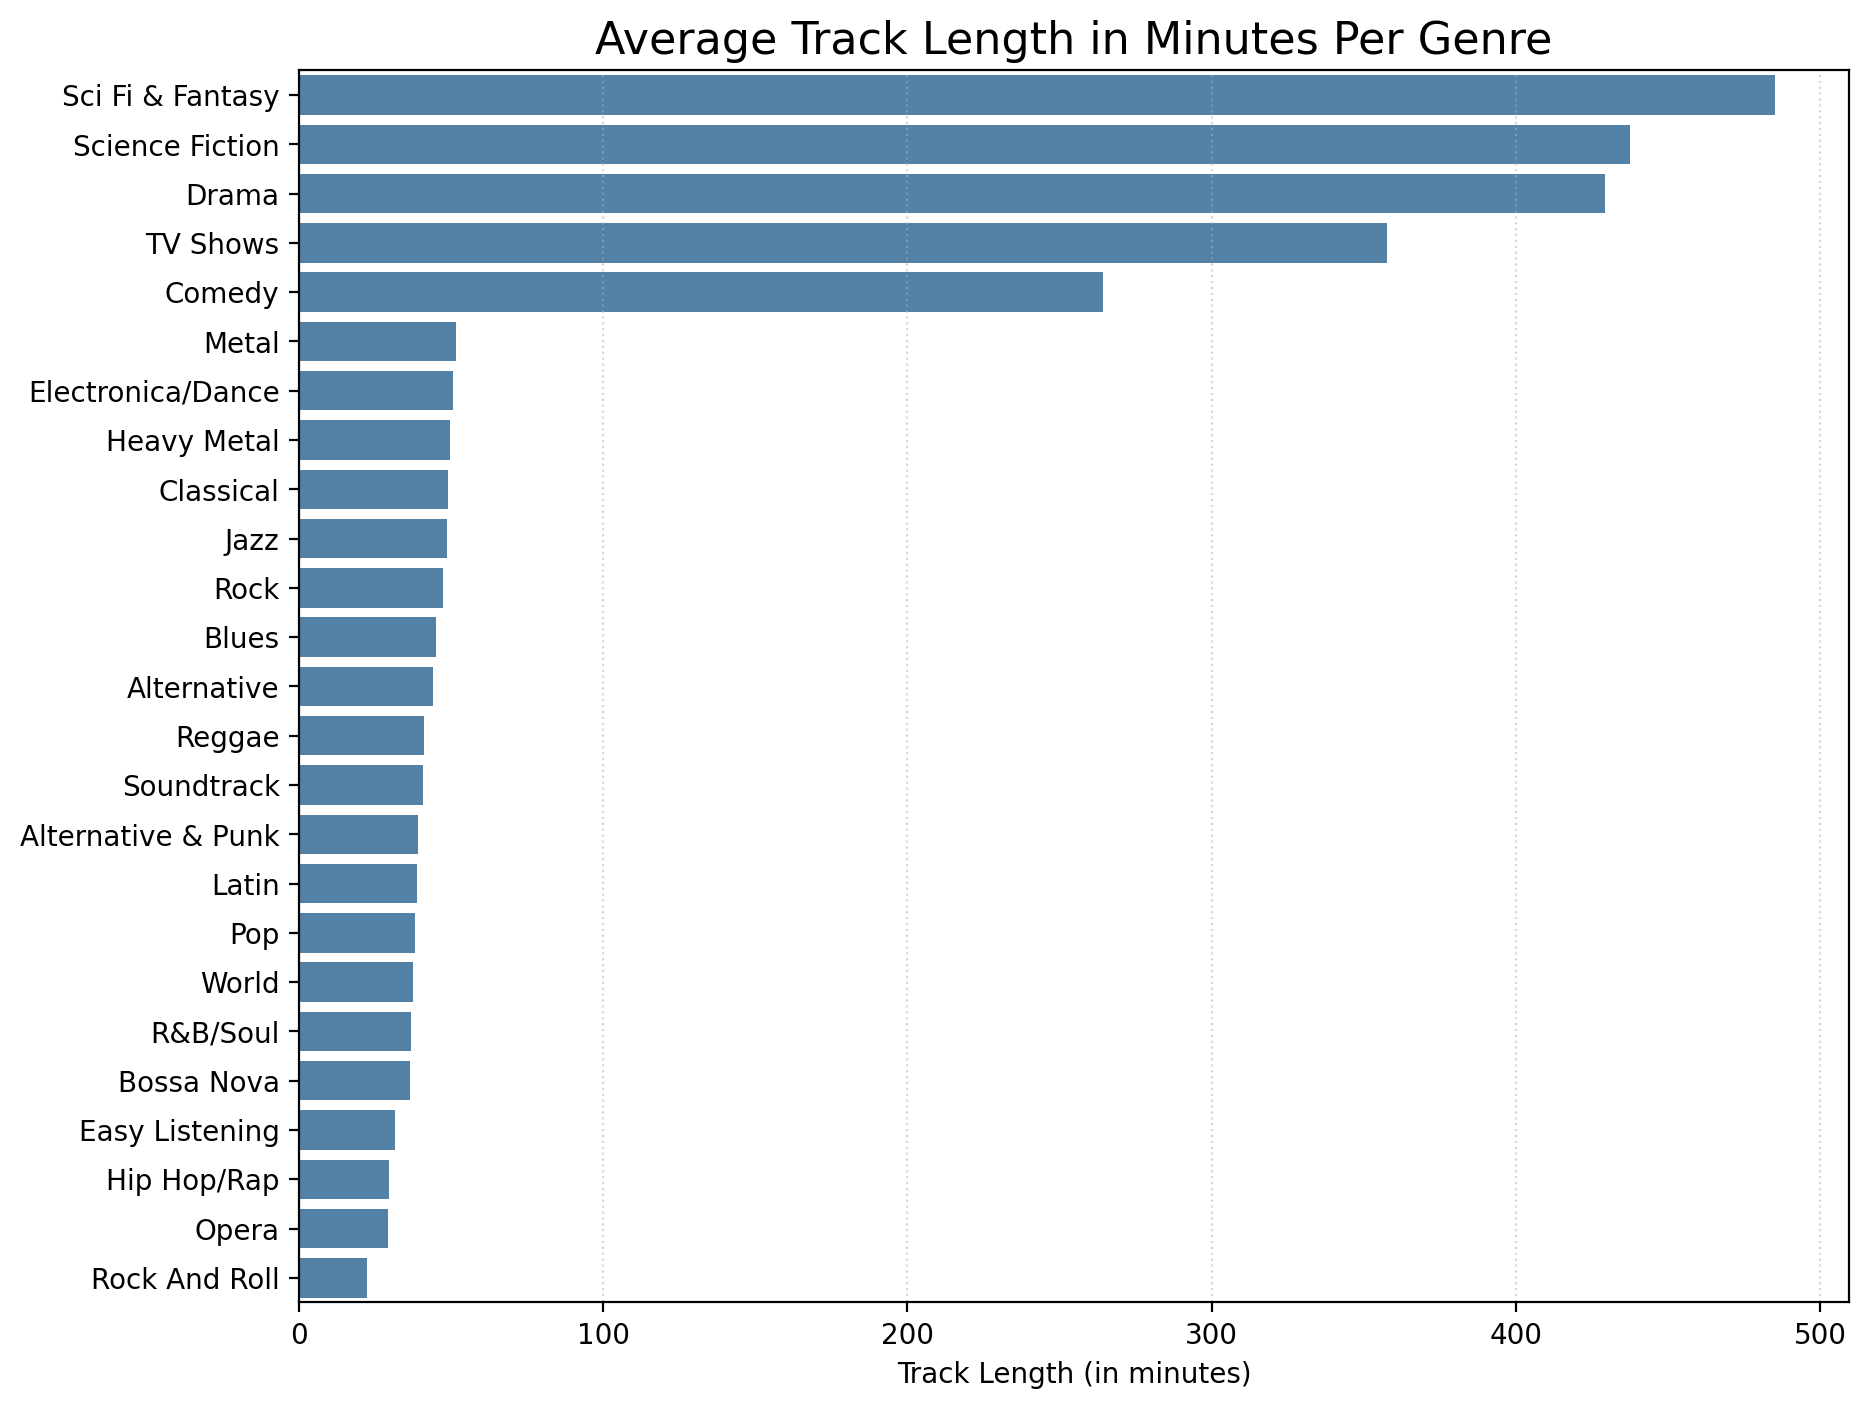

In [4]:
genre_track_length = pd.DataFrame(genre_track_length).sort_values('Avg_Track_Length_Mins', ascending=False)

sns.barplot(y='Genre', x='Avg_Track_Length_Mins', data=genre_track_length, color='steelblue')\
            .set(xlabel='Track Length (in minutes)', ylabel=None, title='Average Track Length in Minutes Per Genre')
plt.grid(axis='x', ls=':', alpha=0.5)
plt.show()

- Average track length is usually less than one hour, except in 5 genres, where it is around 4 to 8 hours. 
- These genres are [Sci Fi & Fantasy - Science Fiction – Drama - TV Shows – Comedy].

## Question 2: What is the count of purchased tracks per media type?

In [5]:
%%sql purchased_media_types <<
SELECT MediaType.Name AS Media_Type,
        SUM(InvoiceLine.Quantity) AS Count
FROM MediaType
    JOIN Track USING (MediaTypeId)
    JOIN InvoiceLine USING (TrackId)
GROUP BY 1
ORDER BY 2 DESC;

 * sqlite:///chinook_db.db
Done.
Returning data to local variable purchased_media_types


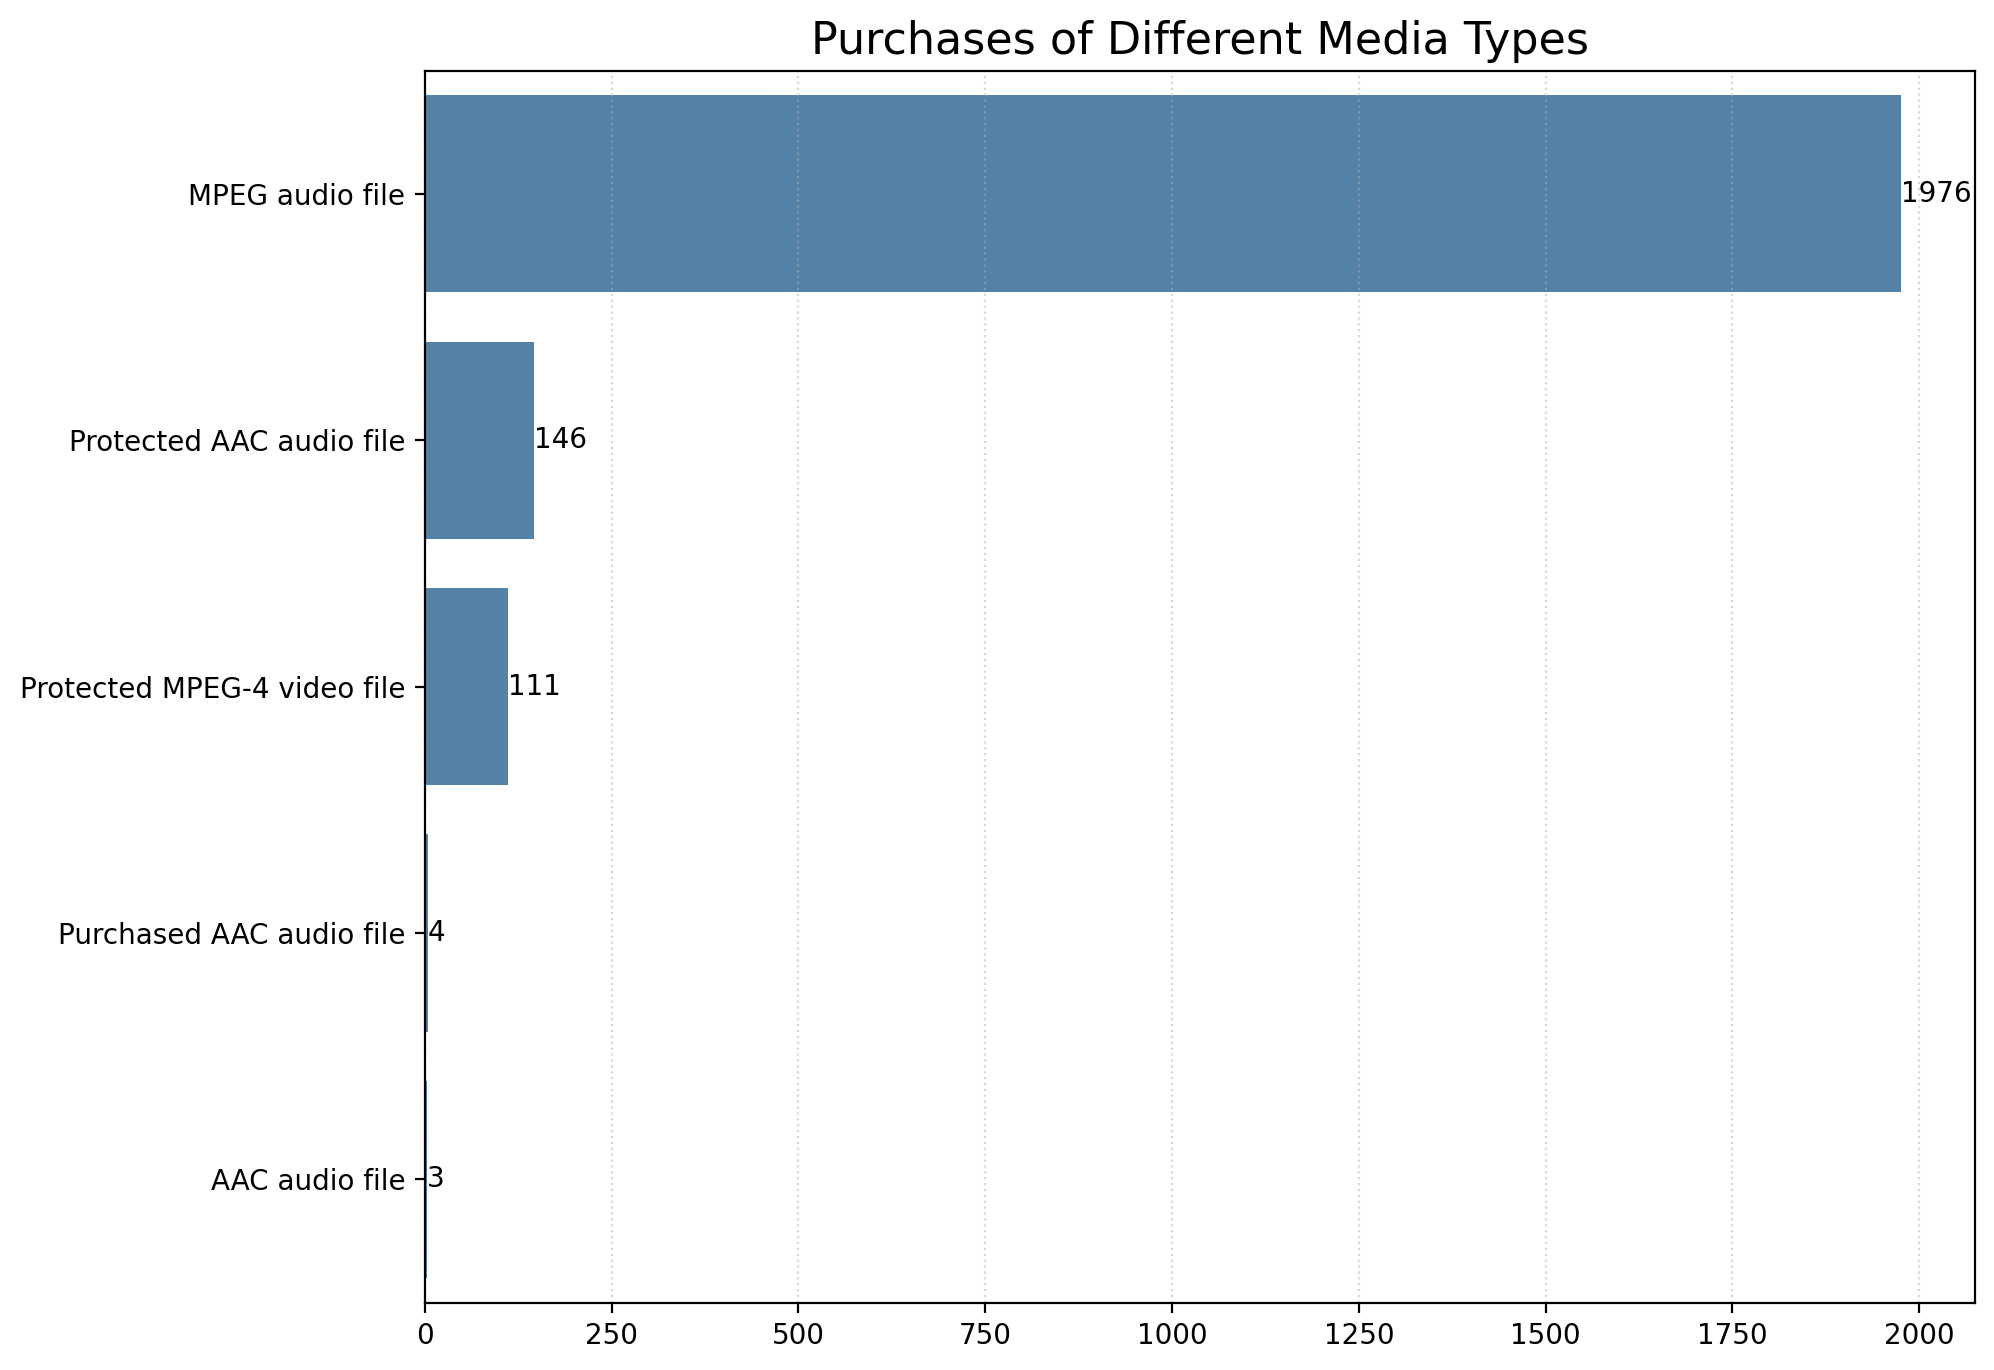

In [6]:
purchased_media_types = pd.DataFrame(purchased_media_types).sort_values('Count', ascending=False)

fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(y='Media_Type', x='Count', data=purchased_media_types, color='steelblue', ax=ax)\
            .set(xlabel=None, ylabel=None, title='Purchases of Different Media Types')
ax.bar_label(ax.containers[0])
plt.grid(axis='x', ls=':', alpha=0.5)
plt.show()

- Most purchased media type is MPEG audio file, with around 88% of total purchased tracks.

## Question 3: What are the top sold genres per country?

In [7]:
%%sql genres_country <<

WITH Country_Genre AS
    (SELECT Customer.Country AS Country,
            Genre.Name AS Genre,
            COUNT(*) AS Purchases
    FROM Customer
        JOIN Invoice USING (CustomerId)
        JOIN InvoiceLine USING (InvoiceId)
        JOIN Track USING (TrackId)
        JOIN Genre USING (GenreId)
    GROUP BY 1, 2)

SELECT T1.Country, T1.Genre
FROM Country_Genre AS T1
    JOIN (SELECT Country, MAX(Purchases) AS Max_Purchases
            FROM Country_Genre GROUP BY Country) AS T2
    ON T1.Country = T2.Country AND T1.Purchases = T2.Max_Purchases;

 * sqlite:///chinook_db.db
Done.
Returning data to local variable genres_country


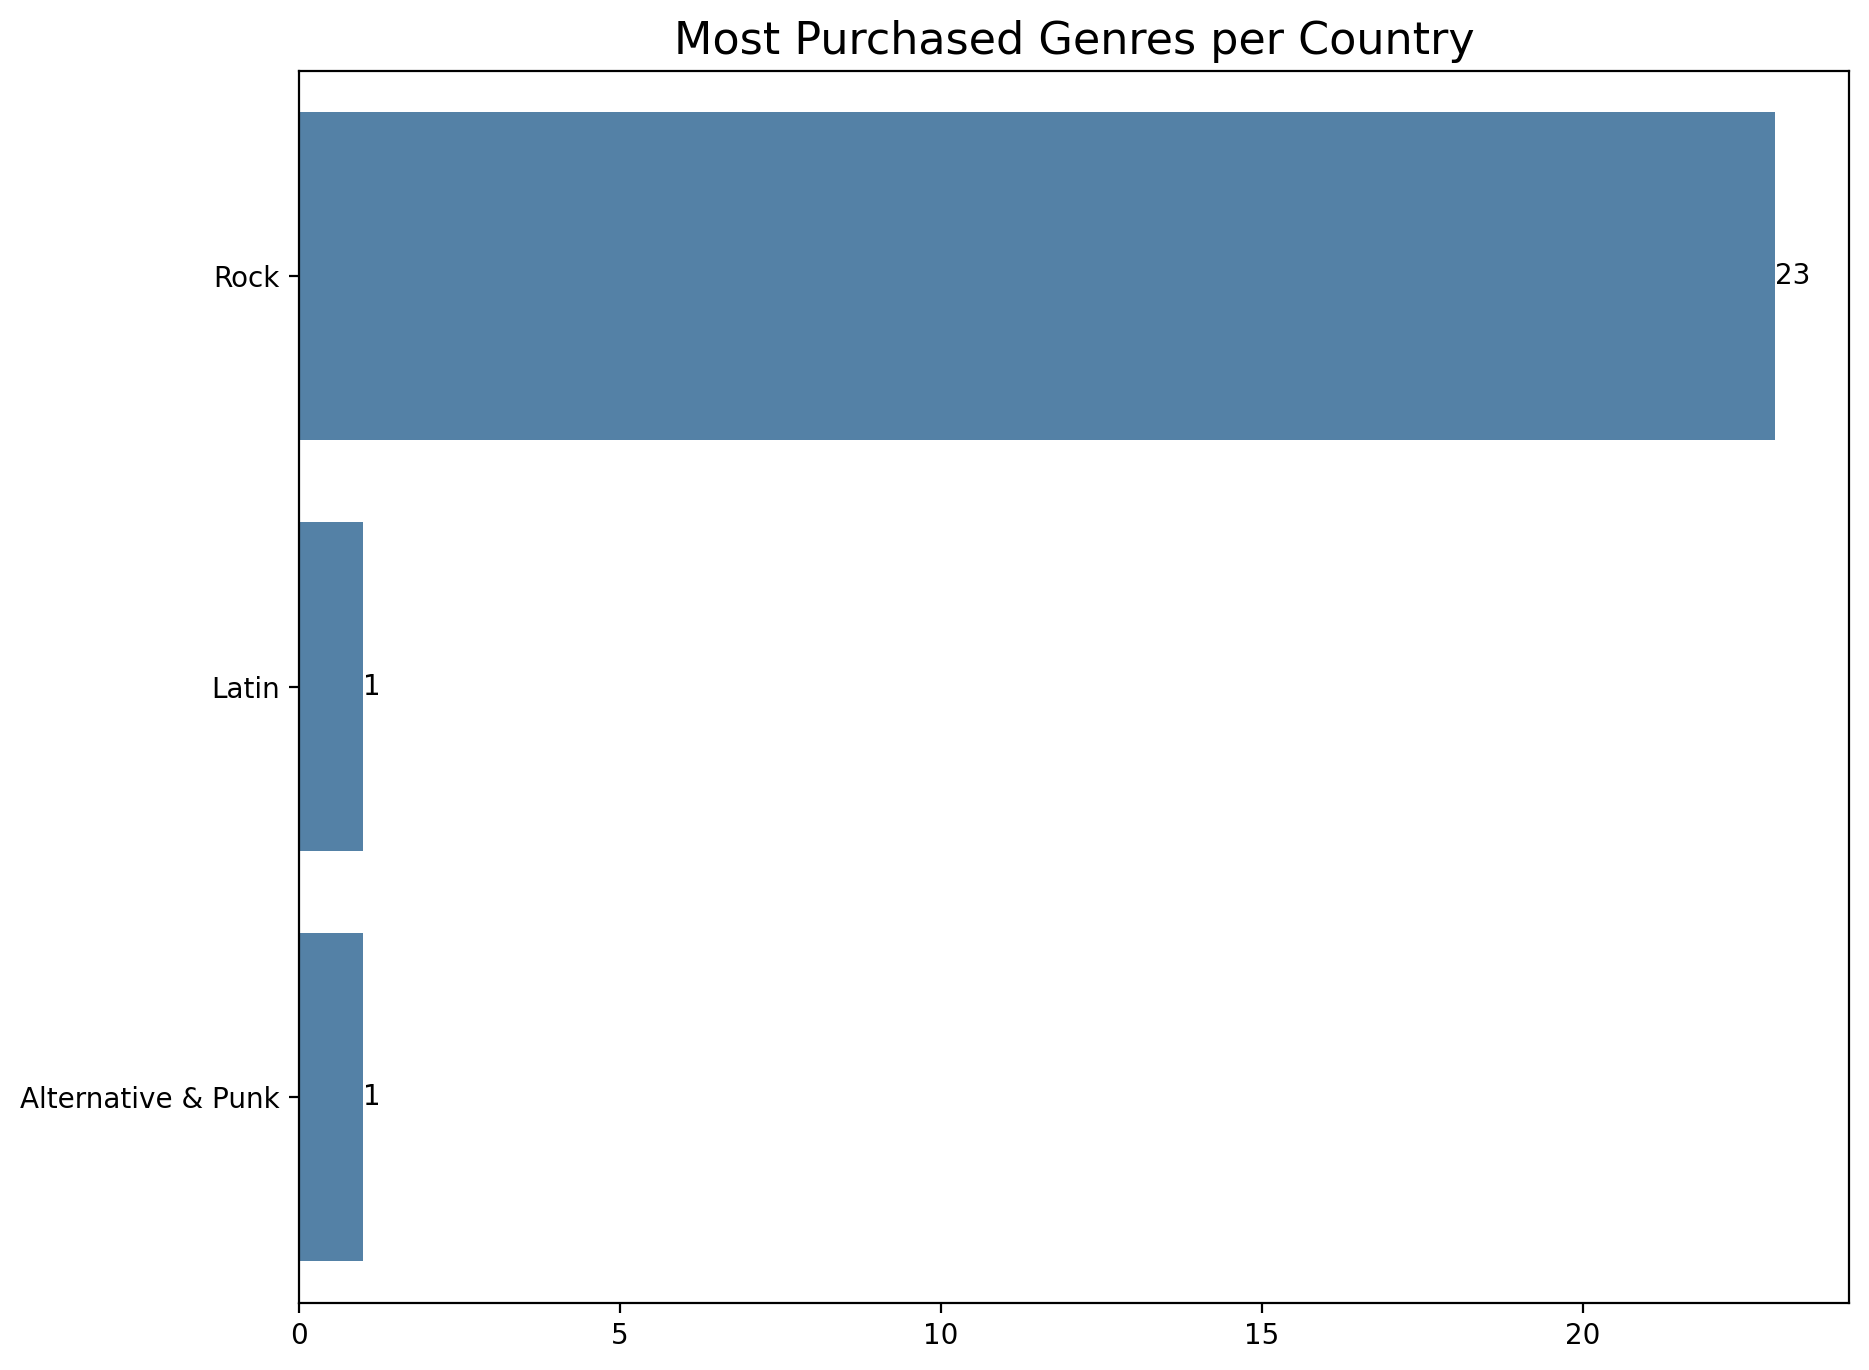

In [8]:
genres_country = pd.DataFrame(genres_country).sort_values('Genre', ascending=False)

fig, ax = plt.subplots(figsize=(10, 8))
sns.countplot(y='Genre', data=genres_country, color='steelblue', ax=ax)\
            .set(xlabel=None, ylabel=None, title='Most Purchased Genres per Country')
ax.bar_label(ax.containers[0])
plt.show()

In the majority of countries, most purchased genre is Rock.
Two countries are the exception, Sweden which has Latin genre as the most common genre. And Argentina which has both Rock and Alternative & Punk with equal purchase count. 

## Question 4: Which employee made the highest revenue from sales outside of USA?

In [9]:
%%sql revenues_abroad <<
SELECT Employee.FirstName || " " || Employee.LastName AS Employee,
        ROUND(SUM(Invoice.Total), 2) AS Sales
FROM Employee
    JOIN Customer ON Employee.EmployeeId = Customer.SupportRepId
    JOIN Invoice USING (CustomerId)
WHERE Customer.Country != "USA"
GROUP BY 1
ORDER BY 2 DESC;

 * sqlite:///chinook_db.db
Done.
Returning data to local variable revenues_abroad


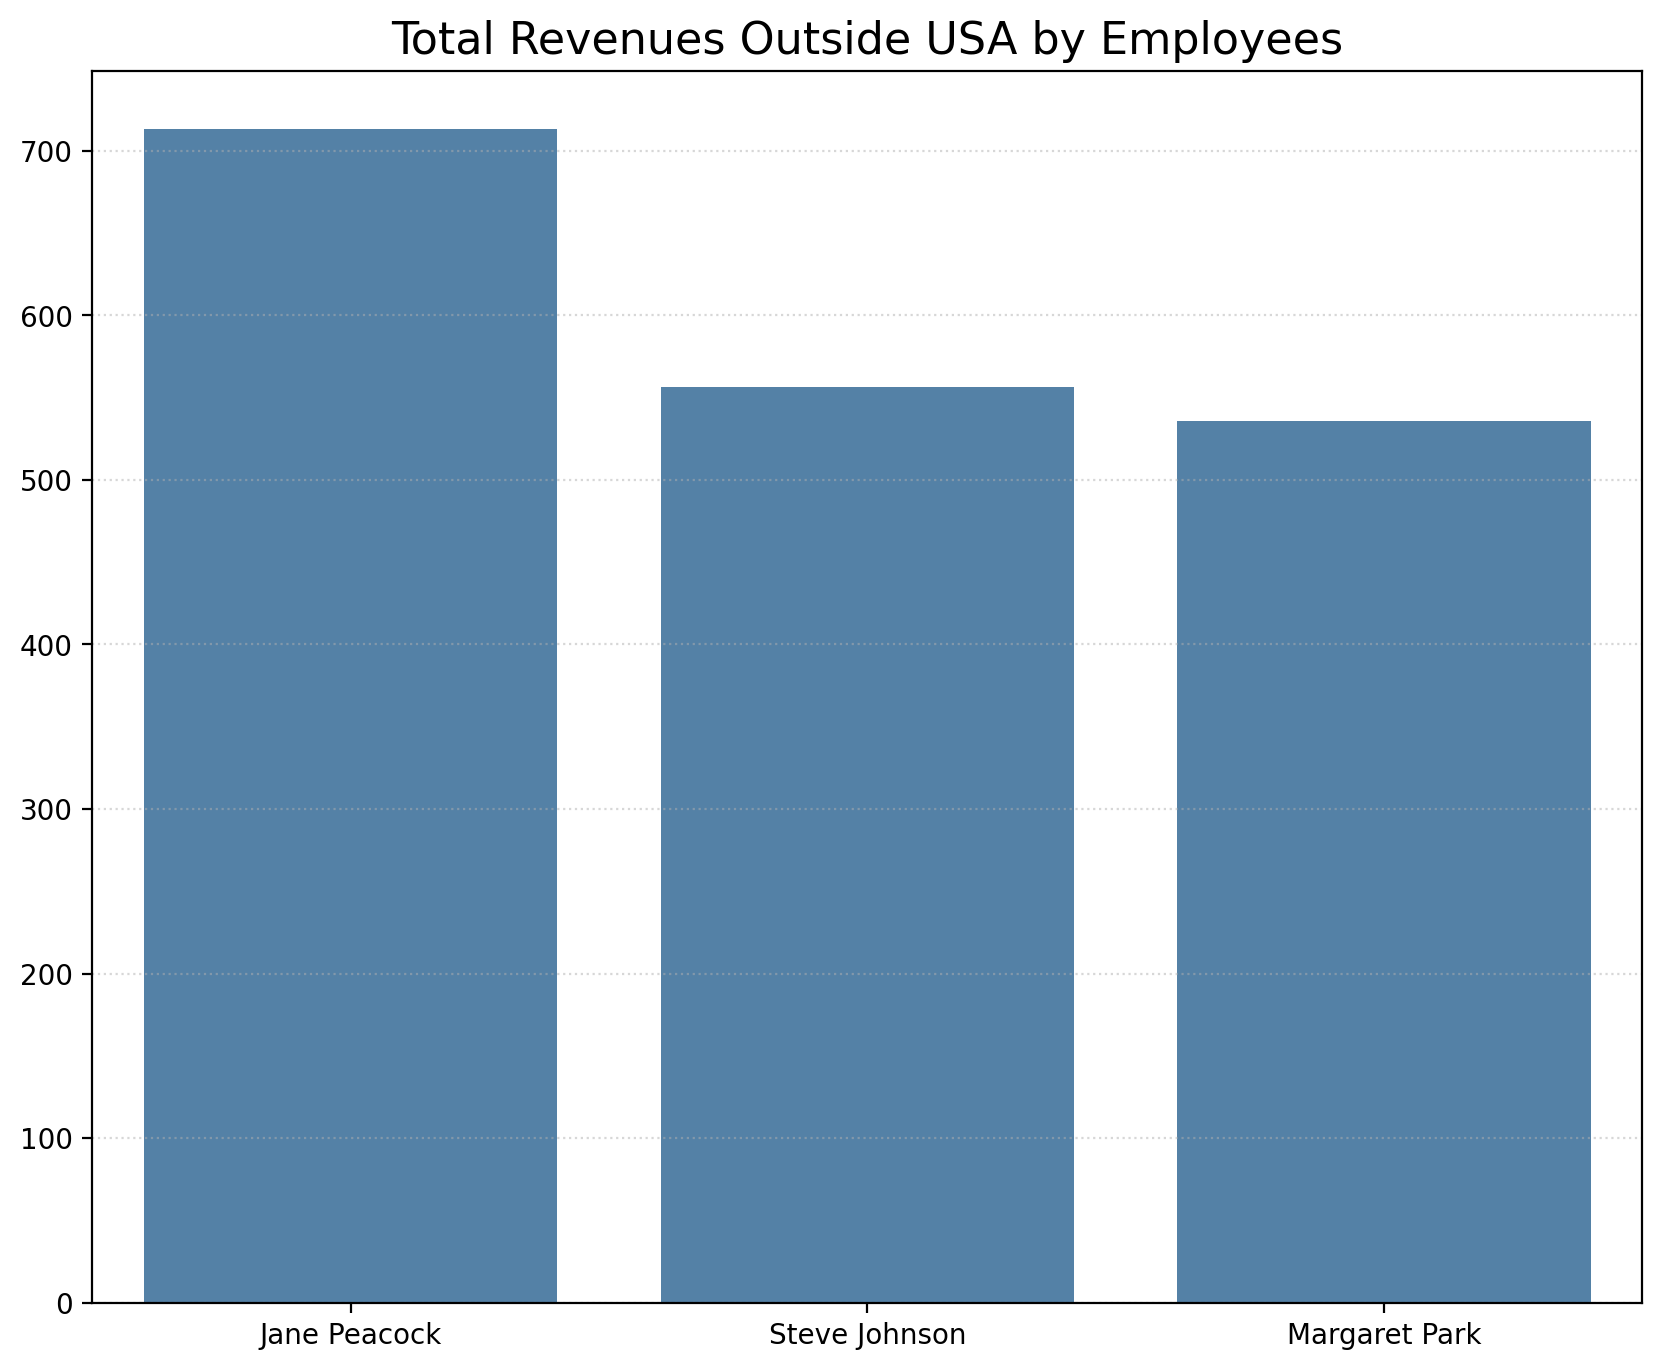

In [10]:
revenues_abroad = pd.DataFrame(revenues_abroad)
revenues_abroad

sns.barplot(y='Sales', x='Employee', data=revenues_abroad, color='steelblue')\
            .set(xlabel=None, ylabel=None, title='Total Revenues Outside USA by Employees')
plt.grid(axis='y', ls=':', alpha=0.5)
plt.show()

- Jane Peacock has the highest sales revenues outside USA.

## Question 5: For each country, what is the average invoice amount and number of invoices?

In [11]:
%%sql avg_invoice <<
SELECT Customer.Country,
        ROUND(AVG(Invoice.Total),2) AS Avg_Per_Invoice,
        COUNT(*) AS Count
FROM Customer
    JOIN Invoice USING (CustomerId)
GROUP BY 1
ORDER BY 3 DESC;

 * sqlite:///chinook_db.db
Done.
Returning data to local variable avg_invoice


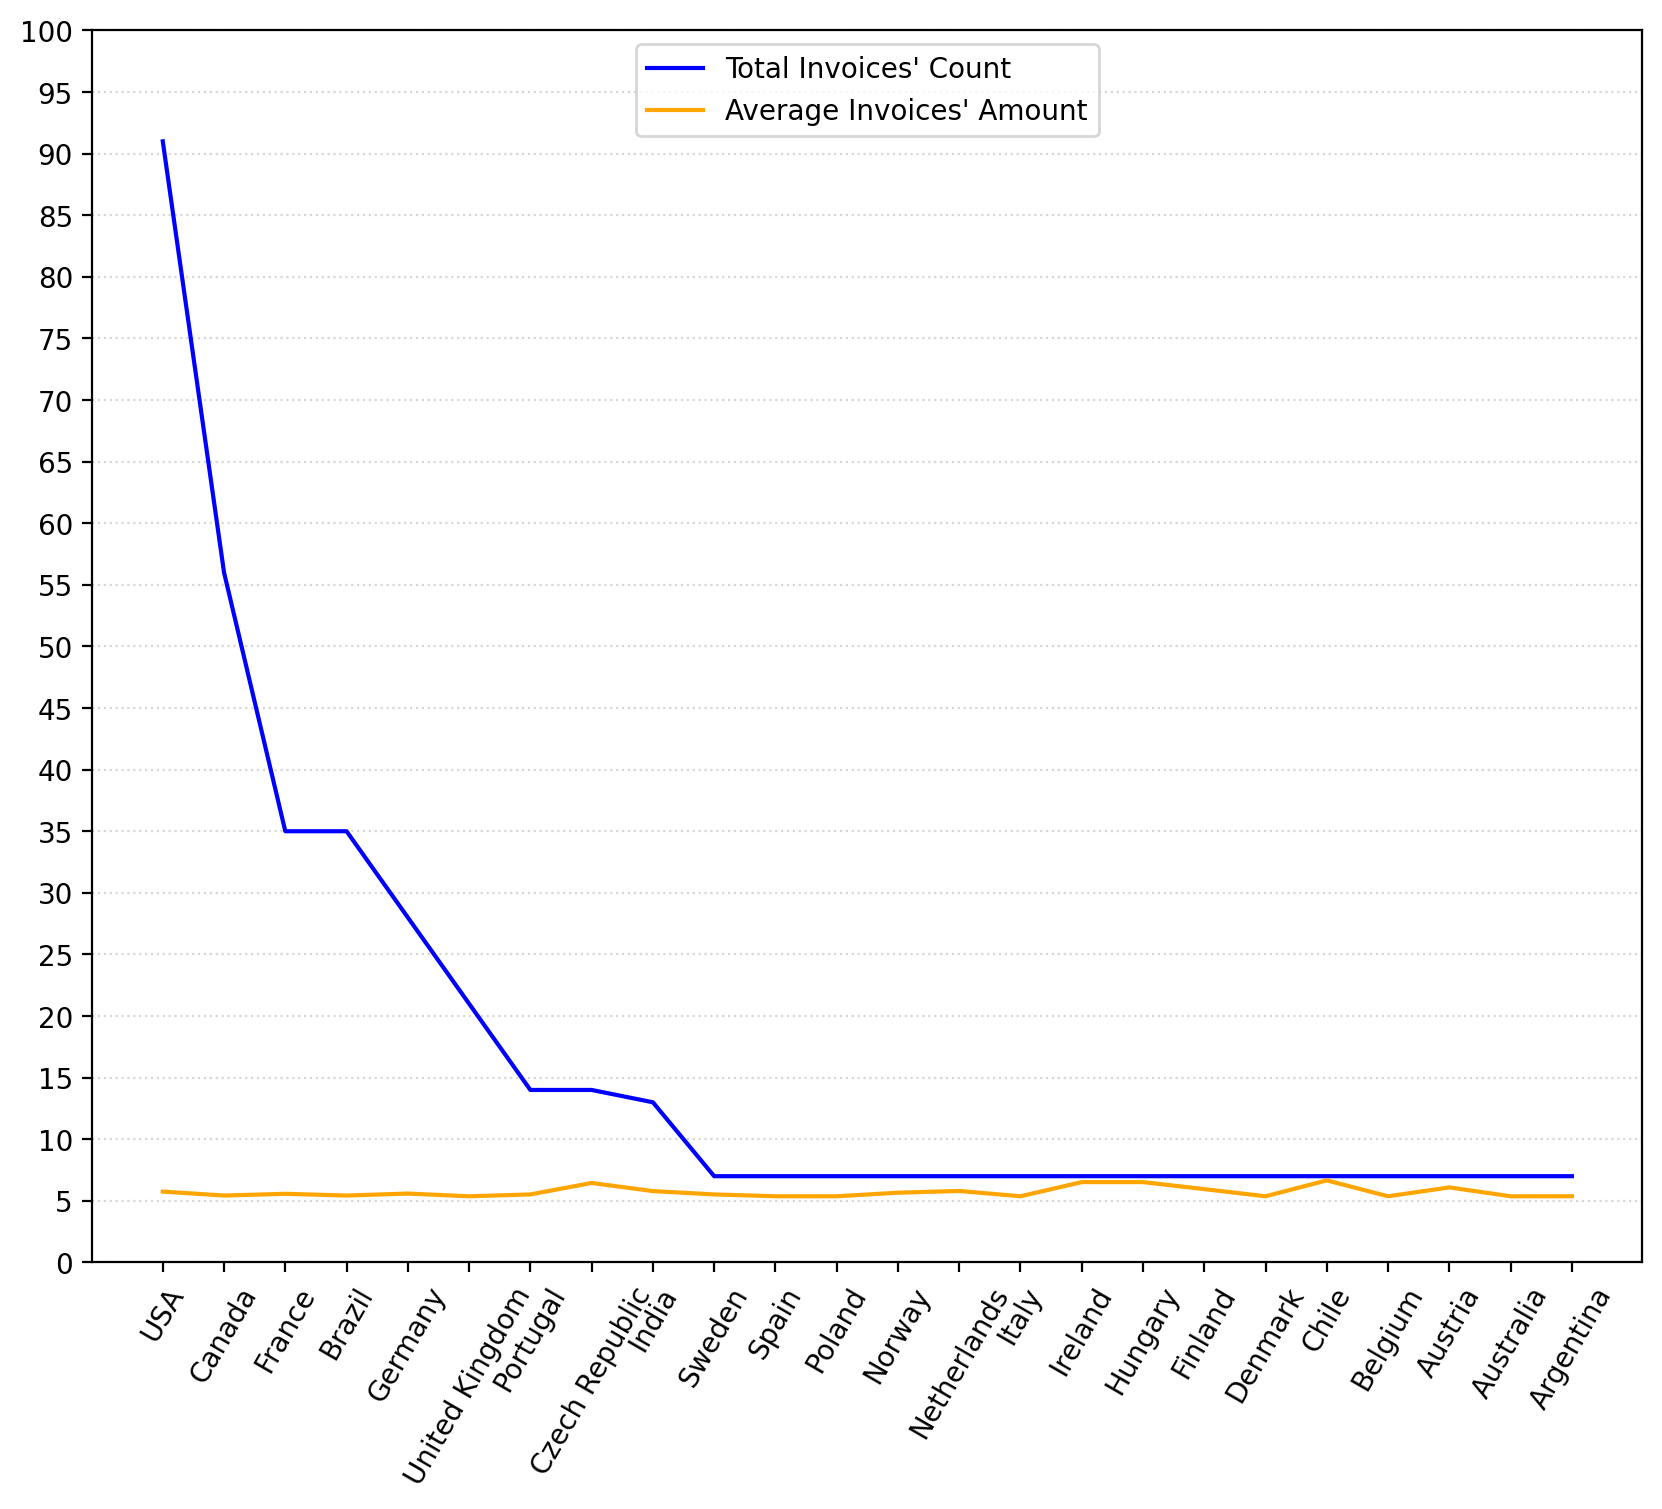

In [12]:
avg_invoice = pd.DataFrame(avg_invoice)
avg_invoice

sns.lineplot(data=avg_invoice, x='Country', y='Count', color='blue', label="Total Invoices' Count").set(xlabel=None, ylabel=None)
sns.lineplot(data=avg_invoice, x='Country', y='Avg_Per_Invoice', color='orange', label="Average Invoices' Amount").set(xlabel=None, ylabel=None)
plt.yticks(range(0,101,5))
plt.grid(axis='y', ls=':', alpha=0.5)
plt.xticks(rotation = 60)
plt.legend(loc='upper center')
plt.show()

Even though number of invoices varies across countries, average invoice amount is almost the same across all of them, ranging from 5 to 7 USD. 

## Question 6: Who are the employees and to whom each of them reports to?

In [14]:
%%sql employees_reporting <<
SELECT T1.FirstName || ' ' || T1.LastName AS Employee,
        T1.Title AS Employee_Title,
        T2.FirstName || ' ' || T2.LastName AS ReportsTo,
        T2.Title
FROM Employee AS T1
    LEFT JOIN Employee AS T2
    ON T1.ReportsTo = T2.EmployeeId

 * sqlite:///chinook_db.db
Done.
Returning data to local variable employees_reporting


In [15]:
employees_reporting = pd.DataFrame(employees_reporting)

def highlight(row):
    value1 = row.loc["Employee_Title"]
    value2 = row.loc["Title"]
    if value1 == "General Manager":
        color = 'lightgreen'
    elif value2 == "General Manager":
        color= 'pink'
    else:
        color = ''
    return ['background-color: %s' % color for r in row]

employees_reporting.style.apply(highlight, axis=1)\
    .applymap(lambda x: 'font-weight: bold' if x=="General Manager" else '')

,Employee,Employee_Title,ReportsTo,Title
0,Andrew Adams,General Manager,None,None
1,Nancy Edwards,Sales Manager,Andrew Adams,General Manager
2,Jane Peacock,Sales Support Agent,Nancy Edwards,Sales Manager
3,Margaret Park,Sales Support Agent,Nancy Edwards,Sales Manager
4,Steve Johnson,Sales Support Agent,Nancy Edwards,Sales Manager
5,Michael Mitchell,IT Manager,Andrew Adams,General Manager
6,Robert King,IT Staff,Michael Mitchell,IT Manager
7,Laura Callahan,IT Staff,Michael Mitchell,IT Manager


# Final Insights:
- Average track length is usually less than one hour, except in 5 genres, where it is around 4 to 8 hours, these genres are [Sci Fi & Fantasy - Science Fiction – Drama - TV Shows – Comedy].
- Most purchased media type is MPEG audio file, with around 88% of total purchased tracks.
- In the majority of countries, most purchased genre is Rock. Two countries are the exception, Sweden which has Latin genre as the most common genre. And Argentina which has both Rock and Alternative & Punk with equal purchase count.
- Even though number of invoices varies across countries, average invoice amount is almost the same across all of them, ranging from 5 to 7 USD.- Jane Peacock has the highest sales revenues outside USA.
- Andrew Adams is the General Manager, only two employess directly report to him, Nancy Edwards and Michael Mitchell.